### Data Preparation

#### Einlesen der Daten

In [6]:
# Sammlung aller importe
import os
import pandas as pd
import re

import tensorflow as tf
from datasets import load_dataset
from transformers import TFMT5ForConditionalGeneration, MT5Tokenizer, DataCollatorForSeq2Seq
from keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split

In [7]:
#Definition der Funktion zum Einlesen aller TXT Dateien aus den Daten
def find_and_read_txt_files(directory,string):
    # Liste zum Speichern des Inhalts der gefundenen .txt-Dateien und der zugehörigen Dateinamen-Nummer
    data = []

    # Durchsucht die Ordnerstruktur rekursiv nach .txt-Dateien
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Überprüft, ob es eine .txt-Datei ist und das Wort "source" im Dateinamen steht
            if file.endswith('.txt') and string in file:
                file_path = os.path.join(root, file)

                # Liest den Inhalt der .txt-Datei
                with open(file_path, 'r', encoding="latin1") as f:
                    content = f.read()

                    # Findet die Zahl im Dateinamen mithilfe eines regulären Ausdrucks
                    number = re.search(r'[^-]*', file).group()

                    # Fügt den Inhalt und die Zahl dem Datensatz hinzu
                    data.append([content, number])

    # Erstellt einen DataFrame aus den gesammelten Daten
    df = pd.DataFrame(data, columns=[string, 'number'])
    return df



In [4]:
def find_and_read_txt_files(directory,string):
    # Liste zum Speichern des Inhalts der gefundenen .txt-Dateien und der zugehörigen Dateinamen-Nummer
    data = []

    # Durchsucht die Ordnerstruktur rekursiv nach .txt-Dateien
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Überprüft, ob es eine .txt-Datei ist und das Wort "source" im Dateinamen steht
            if file.endswith('.txt') and string in file:
                file_path = os.path.join(root, file)

                # Liest den Inhalt der .txt-Datei
                with open(file_path, 'r', encoding="latin1") as f:
                    content = f.read()

                    # Findet die Zahl im Dateinamen mithilfe eines regulären Ausdrucks
                    number = re.search(r'?P<id>\d+', file).group()

                    # Fügt den Inhalt und die Zahl dem Datensatz hinzu
                    data.append([content, number])

    # Erstellt einen DataFrame aus den gesammelten Daten
    df = pd.DataFrame(data, columns=[string, 'number'])
    return df

In [8]:
directory_path = "/Users/huyduc/Documents/GitHub/Hettich/FileArchive_EDIFACT 2"  # Pfad zum Übergeordneten Ordner
df_target = find_and_read_txt_files(directory_path,'target')
df_source = find_and_read_txt_files(directory_path,'source')
#print(df)

In [4]:
df_target.number.nunique()

16551

In [5]:
df_source.isna().sum()

source    0
number    0
dtype: int64

In [6]:
df_target.number.nunique()

16551

In [9]:
df_merged = pd.merge(df_source, df_target, on='number', how='left')

### Filtern der Daten nach Länge

Wie Frederik bereits in seiner Mail erwähnt hat, hat OpenAI die Limitierung Strings mit einer Länge von insgesamt 25000 Zeichen pro Zeile nicht zu tokenisieren. Das heißt wir filtern alle Bestellungen raus, wo die Zeichenkette aus source und target zusammen größer gleich 25000 sind. 

In [10]:
#Ermitteln der Zeichenlänge aus source und target pro Zeile
df_merged["len_source"]=df_merged["source"].str.len() 
df_merged["len_target"]=df_merged["target"].str.len()

In [16]:
#Aufaddieren dieser Zahlen
df_merged["len"]=df_merged["len_source"]+df_merged["len_target"]
df_merged

,source,number,target,len_source,len_target,len
0,UNB+UNOA:3+4025249000006:14+4008057000000:14+2...,EXT_96861056,"<?xml version=""1.0"" encoding=""UTF-8""?><ORDERS0...",3144,7655,10799
1,UNB+UNOA:3+4025249000006:14+4008057000000:14+2...,EXT_96863929,"<?xml version=""1.0"" encoding=""UTF-8""?><MULTIPL...",10795,25066,35861
2,UNA:+.? 'UNB+UNOD:3+4025248000144:14+400805700...,EXT_96852746,"<?xml version=""1.0"" encoding=""UTF-8""?><ORDERS0...",2994,5748,8742
3,UNB+UNOA:3+4025249000006:14+4008057000000:14+2...,EXT_96849879,"<?xml version=""1.0"" encoding=""UTF-8""?><ORDERS0...",6005,13601,19606
4,UNB+UNOA:3+4025249000006:14+4008057000000:14+2...,EXT_96854582,"<?xml version=""1.0"" encoding=""UTF-8""?><ORDERS0...",2152,5324,7476
...,...,...,...,...,...,...
16266,UNA:+.? 'UNB+UNOD:2+4306517008994:14+400805700...,EXT_100534771,"<?xml version=""1.0"" encoding=""UTF-8""?><ORDERS0...",1411,3175,4586
16267,UNA:+.? 'UNB+UNOD:2+4306517008994:14+400805700...,EXT_100533946,"<?xml version=""1.0"" encoding=""UTF-8""?><ORDERS0...",1299,3035,4334
16268,UNA:+.? 'UNB+UNOD:2+4306517008994:14+400805700...,EXT_100533539,"<?xml version=""1.0"" encoding=""UTF-8""?><ORDERS0...",1476,3378,4854
16269,UNA:+.? 'UNB+UNOD:2+4306517008994:14+400805700...,EXT_100535514,"<?xml version=""1.0"" encoding=""UTF-8""?><ORDERS0...",1298,3102,4400


<Axes: >

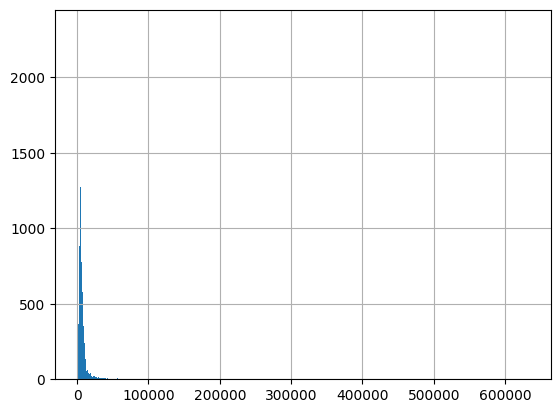

In [14]:
df_merged.len_source.hist(bins=1000)

In [13]:
df_merged[df_merged["len_source"]==632649]#.max()

,source,number,target,len_source,len_target,len
12339,UNA:+.? 'UNB+UNOC:3+4304449000000:14:431556399...,EXT_97535416,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<MULTI...",632649,514435,1147084


In [14]:
df_merged.describe()

,len_source,len_target,len
count,16271.000000,1.627100e+04,1.627100e+04
mean,7447.037920,1.247708e+04,1.992412e+04
std,24720.904125,3.878816e+04,6.178663e+04
min,365.000000,1.603000e+03,2.163000e+03
25%,1331.000000,3.234000e+03,4.634000e+03
50%,4281.000000,7.719000e+03,1.217200e+04
75%,6895.000000,1.159400e+04,1.866800e+04
max,632649.000000,1.375042e+06,1.981733e+06


In [17]:
#Rausfiltern der Dateneinträge, wo len>=25000 ist
df_stripped=df_merged[df_merged["len"]<25000].reset_index(drop=True)
df_stripped

,source,number,target,len_source,len_target,len
0,UNB+UNOA:3+4025249000006:14+4008057000000:14+2...,EXT_96861056,"<?xml version=""1.0"" encoding=""UTF-8""?><ORDERS0...",3144,7655,10799
1,UNA:+.? 'UNB+UNOD:3+4025248000144:14+400805700...,EXT_96852746,"<?xml version=""1.0"" encoding=""UTF-8""?><ORDERS0...",2994,5748,8742
2,UNB+UNOA:3+4025249000006:14+4008057000000:14+2...,EXT_96849879,"<?xml version=""1.0"" encoding=""UTF-8""?><ORDERS0...",6005,13601,19606
3,UNB+UNOA:3+4025249000006:14+4008057000000:14+2...,EXT_96854582,"<?xml version=""1.0"" encoding=""UTF-8""?><ORDERS0...",2152,5324,7476
4,UNB+UNOA:3+4025249000006:14+4008057000000:14+2...,EXT_96870001,"<?xml version=""1.0"" encoding=""UTF-8""?><MULTIPL...",6571,16432,23003
...,...,...,...,...,...,...
14069,UNA:+.? 'UNB+UNOD:2+4306517008994:14+400805700...,EXT_100534771,"<?xml version=""1.0"" encoding=""UTF-8""?><ORDERS0...",1411,3175,4586
14070,UNA:+.? 'UNB+UNOD:2+4306517008994:14+400805700...,EXT_100533946,"<?xml version=""1.0"" encoding=""UTF-8""?><ORDERS0...",1299,3035,4334
14071,UNA:+.? 'UNB+UNOD:2+4306517008994:14+400805700...,EXT_100533539,"<?xml version=""1.0"" encoding=""UTF-8""?><ORDERS0...",1476,3378,4854
14072,UNA:+.? 'UNB+UNOD:2+4306517008994:14+400805700...,EXT_100535514,"<?xml version=""1.0"" encoding=""UTF-8""?><ORDERS0...",1298,3102,4400


In [18]:
df_stripped.len.sum()

153096840

In [42]:
#regex = 
regex=re.compile(r'\sdescr=".*?"')


In [46]:
#df_stripped["source_new"]=df_stripped["source"].str.replace(regex,"", regex=True)
df_stripped["target_new"]=df_stripped["target"].str.replace(regex,"", regex=True)

In [48]:
df_stripped["target_new_len"]=df_stripped["target_new"].str.len()

In [50]:
df_stripped["diff"]=df_stripped["len_target"]-df_stripped["target_new_len"]

<Axes: >

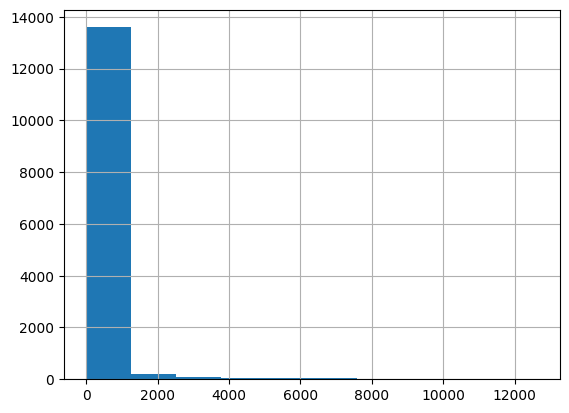

In [58]:
df_stripped["diff"].hist()#.max()#.value_counts()

In [11]:
df_stripped.de#.len_source.max()

13268

In [68]:
#Speichern des Dateneintrages
df_stripped.to_csv("stripped_data.csv")

In [71]:
df_merged.isna().sum()

source        0
number        0
target        0
len_source    0
len_target    0
len           0
dtype: int64

In [73]:
#df_merged2=df_merged.sample(1250)

In [74]:
#df_merged2=df_merged.sample(800)

In [75]:
#df_merged2=df_merged2.sample(100)

Aufteilen des Datensatzes in Trainings und Testdaten

In [78]:
#X_train, X_test, y_train, y_test = train_test_split(df_merged2["source"], df_merged2["target"], test_size=0.2, random_state=42)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(df_stripped["source"], df_stripped["target"], test_size=0.2, random_state=42)

In [81]:
train=pd.DataFrame(columns=["source","target"])#y_train.to_csv("train.csv")
test=pd.DataFrame(columns=["source","target"])

Speicherung der Daten separat als Trainings und Testdaten

In [84]:

train["source"]=X_train
train["target"]=y_train
train=train.reset_index(drop=True)
train.to_csv("stripped_train.csv")
#train.to_csv("train.csv")

In [87]:
test["source"]=X_test
test["target"]=y_test
test.to_csv("stripped_test.csv")
#test.to_csv("test.csv")

## Ab dieser Überschrift alles ignorieren

In [ ]:
tokenizer = MT5Tokenizer.from_pretrained("google/mt5-small")
model = TFMT5ForConditionalGeneration.from_pretrained("google/mt5-small")

In [ ]:
url = 'https://drive.google.com/file/d/1wLHcRo5rwpsen4pFLSvCX3WUGBKHFqgx/view?usp=sharing' 
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
orderlines = pd.read_csv(path)


In [ ]:
dataset = load_dataset("csv", data_files=path)
dataset = dataset["train"].shuffle(seed=42)

In [ ]:
dataset

In [ ]:
def preprocess_function(examples):
    padding = "max_length"
    max_length = 200

    inputs = [ex for ex in examples["source"]]
    targets = [ex for ex in examples["target"]]
    model_inputs = tokenizer(inputs, max_length=max_length, padding=padding, truncation=True)
    labels = tokenizer(targets, max_length=max_length, padding=padding, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
train_dataset = dataset.map(preprocess_function, batched=True, desc="Running tokenizer")

data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=tokenizer.pad_token_id,
    pad_to_multiple_of=64,
    return_tensors="np")

In [ ]:
tf_train_dataset = model.prepare_tf_dataset(
    train_dataset,
    collate_fn=data_collator,
    batch_size=8,
    shuffle=True)

In [ ]:
tf_train_dataset

In [ ]:
model.compile(optimizer=Adam(3e-5))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.fit(tf_train_dataset, epochs=10, callbacks=[early_stopping])

In [ ]:
model.predict(train["source"][0])

In [ ]:
import pandas as pd

# read
#df = pd.read_parquet('/Users/huyduc/Downloads/train.parquet')

In [ ]:

#```

#3. **Tokenisierung**:
#Da es sich nicht um eine Standardübersetzung handelt, werden wir den Präfix für die Eingabe weglassen und einfach die Eingabe- und Ausgabetexte tokenisieren.

#```python
#from transformers import MT5Tokenizer

tokenizer = MT5Tokenizer.from_pretrained("google/mt5-small")

def tokenize_data(edifact_texts, idoc_texts):
    src_tokenized = tokenizer(edifact_texts, padding='max_length', truncation=True, max_length=512, return_tensors="pt")
    tgt_tokenized = tokenizer(idoc_texts, padding='max_length', truncation=True, max_length=512, return_tensors="pt")
    return {"input_ids": src_tokenized['input_ids'], "attention_mask": src_tokenized['attention_mask'], "labels": tgt_tokenized['input_ids']}

tokenized_data = tokenize_data(edifact_texts, idoc_texts)


In [ ]:
from transformers import MT5ForConditionalGeneration, Trainer, TrainingArguments

model = MT5ForConditionalGeneration.from_pretrained("google/mt5-small")

training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    evaluation_strategy="epoch",
    logging_dir='./logs',
    logging_steps=500,
    do_train=True,
    do_eval=True,
    output_dir='./results',
    save_total_limit=3,
    push_to_hub=False,
)

# Angenommen, du teilst deinen tokenisierten Daten in Trainings- und Validierungssets auf
train_data = tokenized_data[:int(0.8*len(tokenized_data))]
val_data = tokenized_data[int(0.8*len(tokenized_data)):]

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
)

trainer.train()
#```

#Stellen Sie sicher, dass Sie genügend Datenpunkte für das Training und die Validierung haben und dass Ihre Daten sauber und korrekt formatiert sind. Transformer-basierte Modelle können mit unstrukturierten Daten wie EDIFACT und IDOC umgehen, benötigen aber eine ausreichende Datenmenge und Ressourcen, um gut zu funktionieren.